In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [2]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
            
            for i in range(3):
                maxVDot[i] = max(abs(float(row[4+i])), maxVDot[i])
                maxAlphaDot[i] = max(abs(float(row[7+i])), maxAlphaDot[i])
        routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

387047
16.049999237060547 35.887664794921875 1.0 [19.161849975585938, 8.428146362304688, 11.452590942382812] [0.0880889892578125, 0.8147430419921875, 0.1421051025390625]


Now we have everything stored in routes. Time to generate some test data

In [27]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 300
fwd_data = [20, 40, 60, 80, 100]


all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.2)
# test_routes_id = [randrange(all_routes) for _ in range(test_count)]
test_routes_id = [13, 9, 1, 18, 5]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes_id]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes_id]

#Phi, v, M, IMU_v, IMU_alpha
groups = [5, 15, 4, 20, 20]

input_length = prev_data//groups[0] + prev_data//groups[1] + (prev_data+fwd_data[-1])//groups[2] + 3*prev_data//groups[3] + 3*prev_data//groups[4]
output_length = len(fwd_data)

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx-prev_data : idx+fwd_data[-1]]/maxTorque
            
            phi = phi.reshape(-1, groups[0]).mean(axis=1)
            v = v.reshape(-1, groups[1]).mean(axis=1)
            M = M.reshape(-1, groups[2]).mean(axis=1)
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, groups[3]).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, groups[4]).mean(axis=1) for i in range(3)]
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = route.phi[idx+fwd_data[i]]/maxAngle
            data = (phi, v, M, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2])
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set), test_routes_id)

  0%|          | 0/21 [00:00<?, ?it/s]

26 routes


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

61438 13902 [13, 9, 1, 18, 5]


In [28]:
t0 = train_set[0][0]
print(t0.shape)
print(input_length)

(270,)
270


In [29]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

959
218


In [30]:
# base_size = prev_data//group_base
# IMU_size = prev_data//group_IMU
# torque_size = (prev_data + fwd_data)//group_base
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)


In [31]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()*100
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*100

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 270])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([5, 32])
torch.Size([5])
19589


Epoch 0
Train loss: 1.6591861844062805
Test  loss: 1.3542390750094162 

Epoch 1
Train loss: 0.5890124477446079
Test  loss: 0.2586144923527272 

Epoch 2
Train loss: 0.2910614013671875
Test  loss: 0.1643598756145199 

Epoch 3
Train loss: 0.19042398780584335
Test  loss: 0.1297312066743445 

Epoch 4
Train loss: 0.17568257171660662
Test  loss: 0.1135527031033443 

Epoch 5
Train loss: 0.15138741582632065
Test  loss: 0.09723796091072363 

Epoch 6
Train loss: 0.10015938896685839
Test  loss: 0.08415659905799532 

Epoch 7
Train loss: 0.1027988619171083
Test  loss: 0.07261651141036071 

Epoch 8
Train loss: 0.0814475875813514
Test  loss: 0.06421671812258364 

Epoch 9
Train loss: 0.07375992136076093
Test  loss: 0.05648710631507496 

Epoch 10
Train loss: 0.07668384350836277
Test  loss: 0.05194397914955508 

Epoch 11
Train loss: 0.08308718679472804
Test  loss: 0.04693026007396071 

Epoch 12
Train loss: 0.05031414912082255
Test  loss: 0.04424566862518085 

Epoch 13
Train loss: 0.13201177353039384
Test

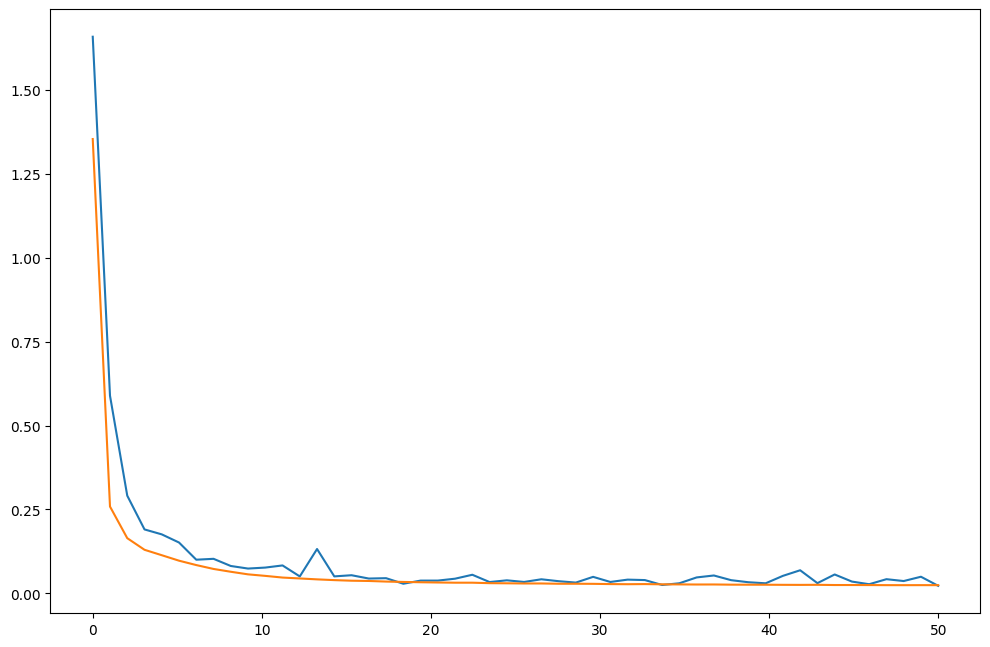

In [32]:
epochs = 50
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    if t%skip == 0:
        loss_e.append(test_loop(test_dataloader, model, loss_fn))

plt.plot(np.linspace(0, epochs, epochs), loss_t)
plt.plot(np.linspace(0, epochs, epochs), loss_e)

In [ ]:
random_sample = test_set[randrange(len(test_set))]
initial_angle = random_sample[0][prev_data//groups[0]-1]*maxAngle
print(initial_angle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
torch_data_output = model(torch_data_input)*maxAngle
print(torch_data_output)

ls_good = [initial_angle] +[random_sample[1][i]*maxAngle for i in range(output_length)]
ls_pred = [initial_angle] +[torch_data_output[i] for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length+1), ls_good)
plt.plot(np.linspace(0, output_length, output_length+1), ls_pred)
plt.plot(np.linspace(0, output_length, output_length+1), np.zeros((output_length+1,)))

3.5999999540431418 initial angle
tensor([3.4500, 3.4500, 3.4500, 3.4500, 3.4500])
tensor([3.1618, 3.0260, 2.9715, 2.9555, 3.0596], grad_fn=<MulBackward0>)


In [33]:
torch.save(model, 'model_s.pth')

In [12]:
model = torch.load('model.pth')
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=940, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
    (5): Tanh()
  )
)
